# Machine Learning Assignment: Regression Task

In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'whitegrid', color_codes = True)

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### จะพยายามแบ่งการทำ Model เป็น 3 model ใหญ่ๆคือ ARIMA, Regression และ Dynamic Regression

## Data Import

เลือกใช้ data จากภายนอกเพราะว่าต้องการค่าที่เป็นเวลาที่จริงขึ้น และสามารถนำข้อมูลอื่นๆ มาใช้ในการ Analysis และใช้ในการสร้าง model ชนิดอื่นด้วยโดย data ที่ได้เป็น data ที่ได้มาจากการ query ใน google bigquery โดยเลือกใช้ประเทศเป็น UK

In [36]:
df_res = pd.read_csv('UK_results-20200503-150942.csv') # from bigquery-public-data.covid19_ecdc.covid_19_geographic_distribution_worldwide
df_mob = pd.read_csv('UK_mobility_results-20200503-152437.csv') # from bigquery-public-data.covid19_google_mobility.mobility_report

In [37]:
df_mob.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

#### df_mob description 
This dataset aims to provide insights into what has changed in response to policies aimed at combating COVID-19. It reports movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential.

This dataset is intended to help remediate the impact of COVID-19. It shouldn’t be used for medical diagnostic, prognostic, or treatment purposes. It also isn’t intended to be used for guidance on personal travel plans. <br>
More at: https://www.google.com/covid19/mobility/data_documentation.html


# 1. ARIMA Model
เนื่องจาก ARIMA Model เป็น model ที่เป็น time series เลยจะใช้แค่ df_res ก่อนแล้วมาดู correlation ในตัว data อีกที

In [38]:
# Safety first
df_res2 = df_res.copy()

In [79]:
df_res = df_res2.copy()

In [80]:
# Set date column into index
df_res = df_res.set_index(['date'])
df_res.index = pd.to_datetime(df_res.index)

In [81]:
# slice dataframe because we use time series model so it only need 1 columns (of independent variables)
df_res = df_res.iloc[:, 3]
df_res.head(3)

date
2019-12-31    0
2020-01-01    0
2020-01-02    0
Name: daily_confirmed_cases, dtype: int64

Text(0, 0.5, 'Amount')

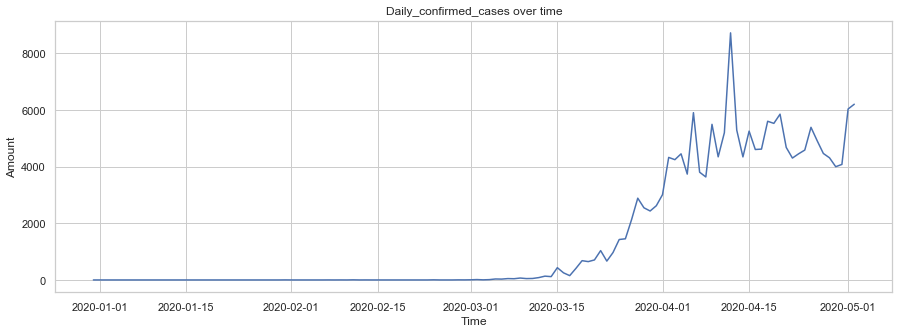

In [86]:
# Observed Daily confirmed Cases
plt.figure(figsize=(15, 5))
plt.plot(df_res)
plt.title('Daily_confirmed_cases over time')
plt.xlabel('Time')
plt.ylabel('Amount')

ดู Autocorrelation ใน daily change ในแต่ละวัน

In [99]:
daily_diff = df_res.diff()

# Compute autocorrelation of daily different of confirmed cases
autocorr_daily = daily_diff.autocorr()
print("The autocorrelation of daily confirmed cases\
 is %4.2f" %(autocorr_daily))

The autocorrelation of daily confirmed cases is -0.30


ค่อนข้างส่งผลต่อค่าในวันถัดๆไป แต่ยังไงก็ต้องมาดู Autocorrelation function ว่า lags เก่าๆ(ค่าวันเก่า)มีผลทางตรงและทางอ้อมต่อวันต่อๆไปยังไงบ้าง

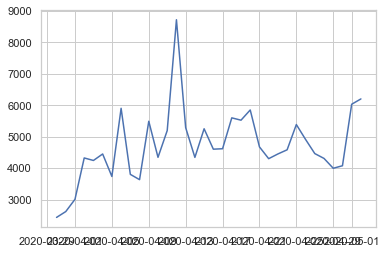

In [105]:
# plot to see if the confirmed cases is always up (check if it not cumulative)
plt.plot(df_res[90:])

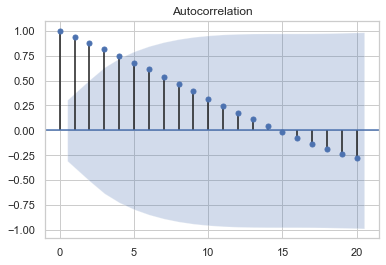

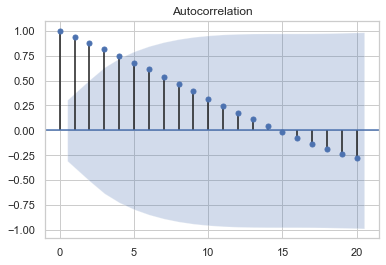

In [111]:
# define only 20 lags for plot and 95 % confidence interval
df_res_acf = acf(df_res)
plot_acf(df_res_acf, lags = 20, alpha = 0.05)

<hr>

เนื่องจากข้อมูลเป็น Non stationarity เนื่องจาก mean และ variance ไม่เป็นค่าคงที่อาจจะทำให้การสร้าง ARIMA Model ทำนายออกมาได้ไม่ดี จึงทำ differencing ข้อมูลก่อนโดย

# 2. Regression model

#### Correlation between all variables

In [67]:
df_res_change = df_res.pct_change()
df_res_change
# At first there might be some 0 data row because there are not
# much infected appear

,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths
date,,,,
2019-12-31,NaN,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN
...,...,...,...,...
2020-04-28,-0.034506,-0.195238,0.028193,0.014051
2020-04-29,-0.072639,1.689349,0.025428,0.037265
2020-04-30,0.020020,-0.125413,0.025294,0.031420


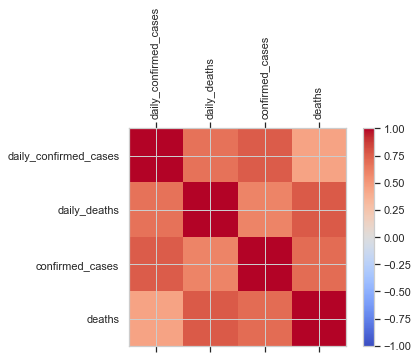

In [74]:
corr = df_res_change.corr()
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(corr, cmap = 'coolwarm', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, len(df_res_change.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation = 90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_res_change.columns)
ax.set_yticklabels(df_res_change.columns)
plt.show()
# https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3

เหมือนว่าจะมีความสัมพันธ์เป็นไปในเชิงบวกเยอะ งั้นเดี๋ยวลองทำ scatter plot ดู

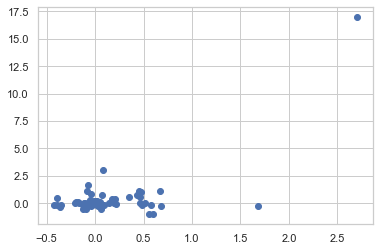

In [75]:
plt.scatter(df_res_change.daily_confirmed_cases, df_res_change.daily_deaths)

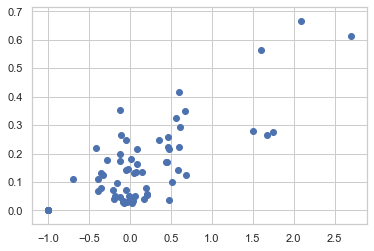

In [76]:
plt.scatter(df_res_change.daily_confirmed_cases, df_res_change.confirmed_cases)

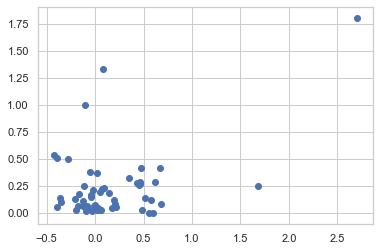

In [77]:
plt.scatter(df_res_change.daily_confirmed_cases, df_res_change.deaths)